# 🎓 **Taller 4.4: Taller de Métodos de clustering basados en particiones Parte 3**


## OBJETIVOS DEL TALLER:
En esta práctica estudiaremos el funcionamiento y la utilización métodos de clustering basados en particiones como el K-medoids.

# 🔧 **CONFIGURACIÓN INICIAL**

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools as it

from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

plt.rcParams['figure.figsize'] = [8, 8]

# 📁 **CARGAR LOS DATASETS Y GRAFICAR SUS DISTRIBUCIONES**

In [44]:
# Cargar dataset artificial
def cargar_dataset(nombre_dataset):
    try:
        # Intentar cargar desde URL alternativa
        data_file_url = "https://raw.githubusercontent.com/SandraNavarrete-docente/aprendizaje-automatico-252601/main/04-MODELOS-NO-SUPERVISADOS/data/"+nombre_dataset
        D = np.array(pd.read_excel(data_file_url,header=0))
        print("✅ Dataset cargado desde URL GitHub")
        return D
    except:
        print("❌ No se pudo cargar el dataset")
        return None

def cargar_dataset_csv(nombre_dataset):
    try:
        # Intentar cargar desde URL alternativa
        data_file_url = "https://raw.githubusercontent.com/SandraNavarrete-docente/aprendizaje-automatico-252601/main/04-MODELOS-NO-SUPERVISADOS/data/"+nombre_dataset
        D = np.array(pd.read_csv(data_file_url,header=0))
        print("✅ Dataset cargado desde URL GitHub")
        return D
    except:
        print("❌ No se pudo cargar el dataset")
        return None

✅ Dataset cargado desde URL GitHub


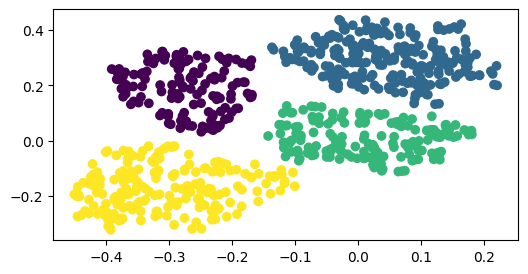

In [45]:
# Cargar dataset
D =cargar_dataset_csv("dataset_cuatro_separables_peque.csv")
Dx = D[:,0:2]
Dy = D[:,2]
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=Dy)

# 🎯 **:Cree el algoritmo K-medoids que tiene un único parámetro: el número de clústeres (K).**

In [46]:
def paso1_elije_medoides(K, Dx):
  # Elegimos los centros iniciales entre el conjunto de datos
  indices_medoides = np.random.choice(Dx.shape[0], K, replace=False)
  cDx = Dx[indices_medoides]
  return cDx

Los centros iniciales elegidos aleatoriamente son:
[[-0.328548   0.284798 ]
 [-0.248515  -0.317351 ]
 [ 0.135712   0.302391 ]
 [ 0.0574121  0.291361 ]]


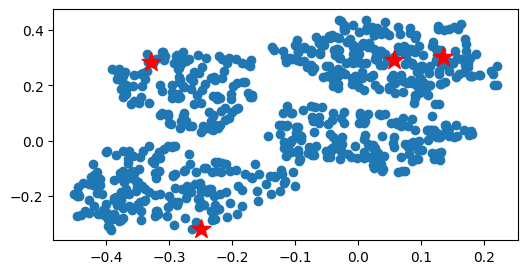

In [47]:
print('Los centros iniciales elegidos aleatoriamente son:')
K=4
cDx = paso1_elije_medoides(K, Dx)
print(cDx)
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1])
ax.scatter(cDx[:,0],cDx[:,1], marker='*', s=200, c='r')

2.   Paso de asignación de datos
En este paso, cada elemento de nuestro dataset se asigna al medoide más cercano basado en la distancia escogida: en nuestro caso, la Euclidiana. Por tanto, tendremos que implementar la siguiente operación:

$$
\DeclareMathOperator*{\argminA}{arg\,min}
\argminA_{c_i \in C} dist\left ( c_i, x \right )^2
$$

In [48]:
# Definimos la distancia euclidiana de una instancia x
# con respecto a un grupo de instancias C
def distancia_euclidiana_grupo(x, C):
    return np.sqrt(np.sum(np.power(C-x,2),axis=1))

def distancia_euclidiana(x, y):
    return np.sqrt(np.sum((x-y)**2))

def matriz_distancias(X, distancia):
    mD = np.zeros((X.shape[0],X.shape[0]))
    for pair in it.product(np.arange(X.shape[0]), repeat=2):
        mD[pair] = distancia(X[pair[0],:],X[pair[1],:])
    return mD

def paso2_asigna_puntos(Dx, cDx):
    Dyp = np.zeros(Dx.shape[0])
    # Buscamos el centro más cercano a cada instancia y la asignamos a ese clúster
    for i in np.arange(Dx.shape[0]):
        # Tenemos que calcular la distancia de cada muestra del dataset Dx[i]
        # a cada centro existente en cDx. Podemos utilizar para ello la función
        # distancia_euclidiana_grupo.

        distancia_punto_a_centros = distancia_euclidiana_grupo(Dx[i], cDx)

        # Una vez calculada la distancia, necesitamos averiguar el índice de
        # la distancia mínima. Para ello, podemos usar la función argmin de numpy.
        pred_y = np.argmin(distancia_punto_a_centros)
        Dyp[i] = pred_y
    return Dyp

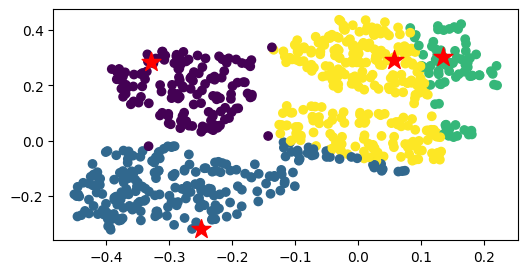

In [49]:
DyM = paso2_asigna_puntos(Dx, cDx)
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=DyM)
ax.scatter(cDx[:,0],cDx[:,1], marker='*', s=200, c='r')

2.   Paso de actualización del medoide

In [50]:
def paso3_actualiza_medoides(Dx, cDx, Dyp, K):
  cDx_ant = cDx.copy()
  # Calcular los nuevos centros
  for k in range(K):
      # En este caso lo que buscamos es el elemento del cluster que reduce la
      # distancia con respecto a todos los demás elementos. Para ello, calculamos
      # las distancias entre todos los elementos del cluster `k` y las almacenamos
      # en `mat`.

      # Primero, obtenemos un vector binario indicando qué elementos de Dyp pertenecen a k
      indices_elementos_k = np.where(Dyp == k)[0]

      # Luego calculamos las distancias entre cada uno de los elementos de `Dx`
      # que nuestra predicción dice que pertenecen al custer `k` y los demás.
      if len(indices_elementos_k) > 0:
        Dx_k = Dx[indices_elementos_k]
        mat = matriz_distancias(Dx_k, distancia_euclidiana)

        # Ahora buscamos el elemento con menor distancia dentro del
        # cluster `k` y nos quedamos con su índice (usando np.argmin, que busca
        # el mínimo de un vector y nos devuelve su índice).

        # Find the index of the point within Dx_k that minimizes the sum of distances
        idx_new_medoid_in_cluster = np.argmin(np.sum(mat, axis=1))

        # Get the original index of this new medoid in Dx
        original_idx_new_medoid = indices_elementos_k[idx_new_medoid_in_cluster]

        # Asignamos como centro del cluster al elemento del cluster que ofrece
        # la menor distancia con respecto a todos los demás
        cDx[k,:] = Dx[original_idx_new_medoid]
  return cDx

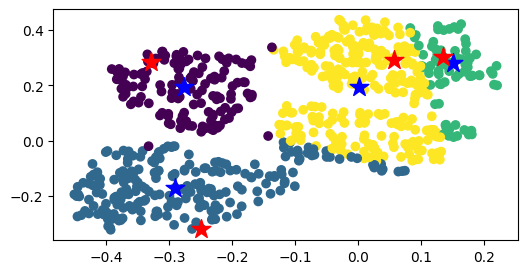

In [51]:
cDx_ant = cDx.copy()
cDx =paso3_actualiza_medoides(Dx, cDx, DyM, K)
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=DyM)
ax.scatter(cDx[:,0],cDx[:,1], marker='*', s=200, c='b')
ax.scatter(cDx_ant[:,0],cDx_ant[:,1], marker='*', s=200, c='r')

Y esto es todo. Este proceso se repite hasta cumplir un criterio de detención:

*   No hay cambios en los puntos asignados a cada cluster
*   La suma de las distancias alcanza un valor mínimo establecido
*   Se alcanza un número máximo de iteraciones

In [52]:
def MyKMedoide(Dx, K):
  cDx =  paso1_elije_medoides(K, Dx)
  # Flag de convergencia
  iterando = True
  Dyp = np.zeros(Dx.shape[0])
  while iterando:
    # Vector auxiliar para guardar los centros de la iteración pasada
    # necesarios para identificar la convergencia
    cDx_ant = cDx.copy()
    Dyp = paso2_asigna_puntos(Dx, cDx)
    # Calcular los nuevos centros
    cDx =  paso3_actualiza_medoides(Dx, cDx, Dyp, K)
    iterando = (np.absolute(np.sum(cDx-cDx_ant)) > 0.00001)
  return cDx, Dyp

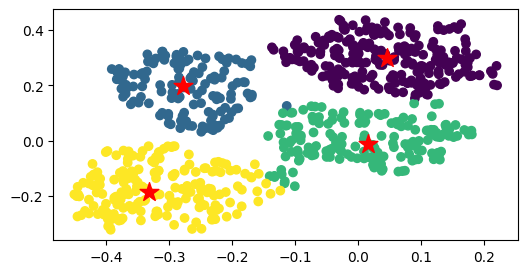

In [53]:
cDx, Dyp = MyKMedoide(Dx, 4)
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp)
ax.scatter(cDx[:,0],cDx[:,1], marker='*', s=200, c='r')

# 🎯 **EJ 3: COMPARA KMEDOIDS CON KMEANS++**


K-Means++:


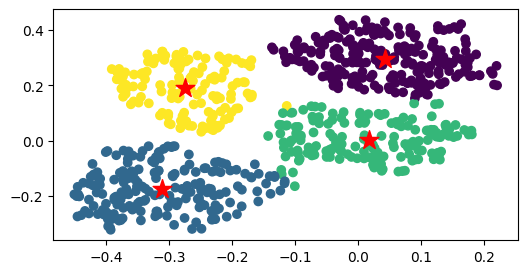

In [54]:
from sklearn.cluster import KMeans

modelo = KMeans(4, random_state=0, n_init='auto')
modelo.fit(Dx)
# modelo.predict(Dx) is not needed here as labels_ is already available after fit
Dyp_sk = modelo.labels_
# Obtener los centros de los clústeres
cDx_sk = modelo.cluster_centers_

print('K-Means++:')
# Ver asignaciones finales
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp_sk)
ax.scatter(cDx_sk[:,0],cDx_sk[:,1], marker='*', s=200, c='r')

### Calcula las metricas que te permita determinar que algoritmo agrupo mejor los datos y escbribe la conclusión.

In [55]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, adjusted_rand_score

# Cálculo de métricas para MyKMedoide
sil_med = silhouette_score(Dx, Dyp)
ch_med = calinski_harabasz_score(Dx, Dyp)
ari_med = adjusted_rand_score(Dy, Dyp)

# Cálculo de métricas para K-Means++
sil_km = silhouette_score(Dx, Dyp_sk)
ch_km = calinski_harabasz_score(Dx, Dyp_sk)
ari_km = adjusted_rand_score(Dy, Dyp_sk)

# Mostrar resultados
print(f"{'Métrica':<25} | {'K-Medoids':<10} | {'K-Means++':<10}")
print("-" * 30)
print(f"{'Silueta (↑ mejor)':<25} | {sil_med:.4f}   | {sil_km:.4f}")
print(f"{'Calinski-Harabasz (↑ mejor)':<25} | {ch_med:.2f}   | {ch_km:.2f}")
print(f"{'Rand Ajustado (ARI) (↑ mejor)':<25} | {ari_med:.4f}   | {ari_km:.4f}")
print("-" * 30)

Métrica                   | K-Medoids  | K-Means++ 
------------------------------
Silueta (↑ mejor)         | 0.5361   | 0.5362
Calinski-Harabasz (↑ mejor) | 1342.42   | 1346.00
Rand Ajustado (ARI) (↑ mejor) | 0.9561   | 0.9725
------------------------------


Conclusión

El algoritmo K-Means++ obtuvo un mejor desempeño general en este experimento, superando a K-Medoids en todas las métricas evaluadas. Aunque la diferencia en las medidas intrínsecas (Silueta y Calinski-Harabasz) es sutil, el alto valor del ARI (0.9725) confirma que la inicialización inteligente de K-Means++  fue más efectiva para recuperar la estructura verdadera del dataset que el método K-Medoids.

K-Means++ proporcionó una segmentación más precisa y compacta. Esto sugiere que los datos podrían tener una distribución más esférica o carecer de valores atípicos extremos que afecten negativamente el cálculo de los centroides de K-Means

### ahora prueba con otro dataset, calcula las metricas que te permita determinar que algoritmo agrupo mejor los datos y escbribe la conclusión.

✅ Dataset cargado desde URL GitHub


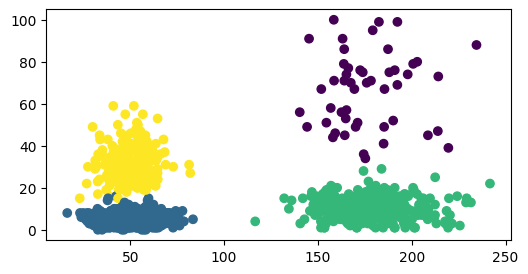

In [56]:
# Cargar dataset
D =cargar_dataset("dataset_cuatro_diferente_densidad.xlsx")
Dx = D[:,0:2]
Dy = D[:,2]
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=Dy)

K-Means++ en el nuevo dataset:


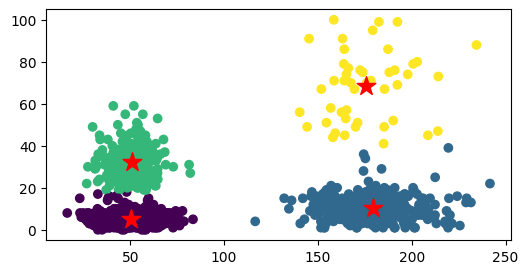

In [57]:
modelo_km_new = KMeans(n_clusters=K, random_state=0, n_init='auto')
modelo_km_new.fit(Dx)
Dyp_sk_new = modelo_km_new.labels_
cDx_sk_new = modelo_km_new.cluster_centers_

print('K-Means++ en el nuevo dataset:')
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp_sk_new)
ax.scatter(cDx_sk_new[:,0],cDx_sk_new[:,1], marker='*', s=200, c='r')

K-Medoides en el nuevo dataset:


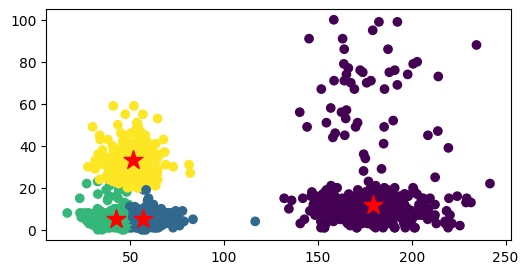

In [58]:
cDx_new, Dyp_new = MyKMedoide(Dx, K)

print('K-Medoides en el nuevo dataset:')
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp_new)
ax.scatter(cDx_new[:,0],cDx_new[:,1], marker='*', s=200, c='r')

In [60]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, adjusted_rand_score

# Cálculo de métricas para MyKMedoide en el nuevo dataset
sil_med_new = silhouette_score(Dx, Dyp_new)
ch_med_new = calinski_harabasz_score(Dx, Dyp_new)
ari_med_new = adjusted_rand_score(Dy, Dyp_new)

# Cálculo de métricas para K-Means++ en el nuevo dataset
sil_km_new = silhouette_score(Dx, Dyp_sk_new)
ch_km_new = calinski_harabasz_score(Dx, Dyp_sk_new)
ari_km_new = adjusted_rand_score(Dy, Dyp_sk_new)
inertia_km_new = modelo_km_new.inertia_

# Mostrar resultados
print(f"{'Métrica':<25} | {'K-Medoids (Nuevo)':<20} | {'K-Means++ (Nuevo)':<20}")
print("-" * 70)
print(f"{'Silueta (↑ mejor)':<25} | {sil_med_new:.4f}{' ':16} | {sil_km_new:.4f}")
print(f"{'Calinski-Harabasz (↑ mejor)':<25} | {ch_med_new:.2f}{' ':16} | {ch_km_new:.2f}")
print(f"{'Rand Ajustado (ARI) (↑ mejor)':<25} | {ari_med_new:.4f}{' ':16} | {ari_km_new:.4f}")
print(f"{'Inercia (↓ mejor)':<25} | {'N/A':<20} | {inertia_km_new:.4f}")
print("-" * 70)


Métrica                   | K-Medoids (Nuevo)    | K-Means++ (Nuevo)   
----------------------------------------------------------------------
Silueta (↑ mejor)         | 0.5433                 | 0.5900
Calinski-Harabasz (↑ mejor) | 9360.46                 | 10596.23
Rand Ajustado (ARI) (↑ mejor) | 0.4984                 | 0.9908
Inercia (↓ mejor)         | N/A                  | 346980.4510
----------------------------------------------------------------------


Recuperación de la Estructura (ARI): La diferencia más contundente se observa en el Índice Rand Ajustado (ARI). K-Means++ logró un 0.9908, lo que significa que ha identificado la estructura original de los grupos con una precisión casi perfecta (99%).

Calidad de la Separación (Silueta y Calinski-Harabasz):

El Silhouette Score de K-Means++ (0.5900) es superior al de K-Medoids (0.5433), indicando que los puntos están mejor asignados a sus centros y los clusters están más "limpios" y menos solapados.

El índice Calinski-Harabasz es notablemente más alto en K-Means++ (10596.23) frente a K-Medoids (9360.46), lo que confirma una mejor relación entre la cohesión interna de los grupos y la separación entre ellos.

Sensibilidad a la Densidad: Aunque el dataset presenta "diferentes densidades", la distribución espacial de los puntos favorece la lógica de centroides de K-Means++. K-Medoids, al verse obligado a elegir un punto real del dataset como centro, no logró encontrar una posición óptima que compensara las variaciones de densidad de la misma forma que lo hizo el promedio matemático (centroide) de K-Means.

K-Means++ es la opción superior. Ha demostrado ser extremadamente robusto y preciso, logrando una segmentación prácticamente idéntica a la realidad, mientras que K-Medoids mostró un rendimiento mediocre en la comparación.

# 🚀 ¡TALLER FINALIZADO!"